<a href="https://colab.research.google.com/github/abishek-bupathi/dog-breed-identification/blob/master/dog_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!unzip "/content/drive/My Drive/Dog vision/dog-breed-identification.zip" -d "/content/drive/My Drive/Dog vision/"

# Multiclass Dog breed classification

This notebook builds multi-class image classifier using TensorFlow 2.0 and TensorFlow Hub

### 1. Problem

Identifying the breed of the dog given an image of a dog.

### 2. Data

The data used from Kaggle's dog breed identification competition

https://www.kaggle.com/c/dog-breed-identification/data

### 3. Evaluation

A file with prediction probabilities for each dog breed of each test image

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

### 4. Features

Information about the data:
- The data is in the form of images(unstructured) so its best method is to use deep learning/ transfer learning
- There are 120 breeds of dogs (multi-class: 120 different classes)
- There are 10,000+ images in the training set (images with labels)
- There are 10,000+ images in the test set (images without labels)




## 0. Getting the workspace ready
- Import TensorFlow 2.x
- Import TensorFlow Hub
- Initialize and use GPU

In [2]:
# import TensorFlow 2.x and other neccessary tools
import tensorflow as tf
import tensorflow_hub as hub
print("TF version: ", tf.__version__)
print("TF Hub version: ", hub.__version__)

# Check for GPU availability
print("GPU available !" if tf.config.list_physical_devices("GPU")else "GPU not available :(")

TF version:  2.2.0
TF Hub version:  0.8.0
GPU available !


## 1. Getting the Data Ready (Turning into Tensors)

All data should be converted into numeric

In [3]:
# Checking the labels of the data
import pandas as pd
labels_csv = pd.read_csv("/content/drive/My Drive/Dog vision/labels.csv")
print(labels_csv.describe())
labels_csv.head()

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     d04b64a9c43afe278479d36e0f196bc1  scottish_deerhound
freq                                   1                 126


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


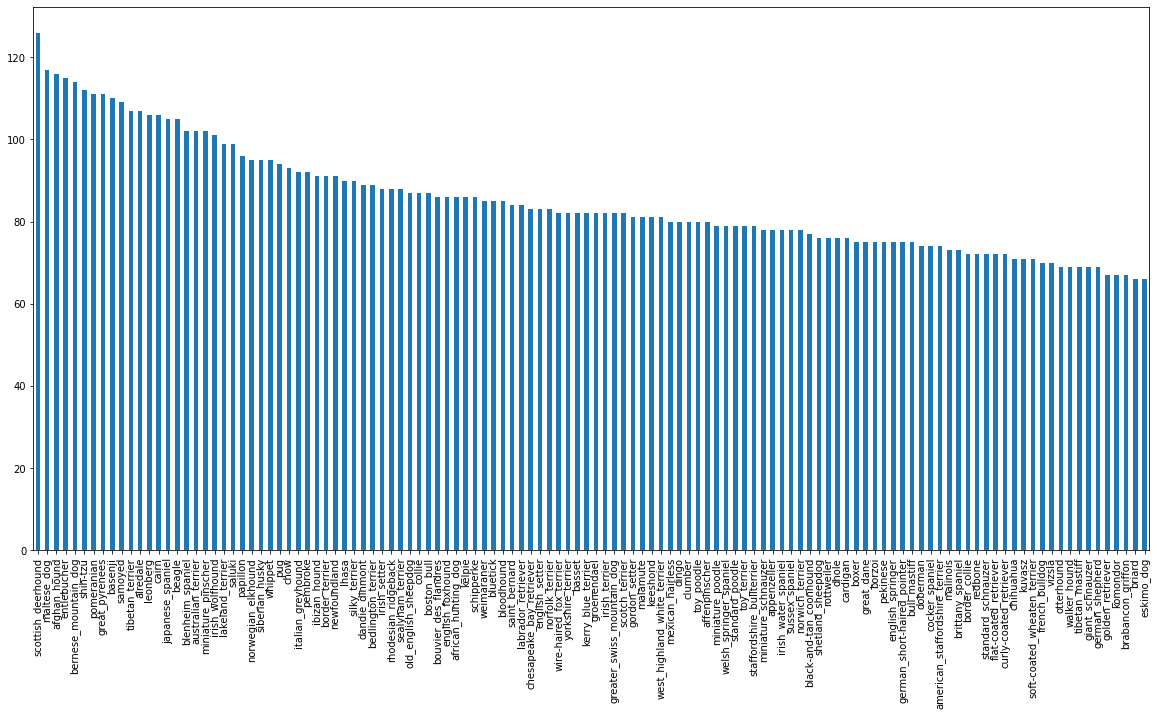

In [4]:
# Number of images of each breed
labels_csv["breed"].value_counts().plot.bar(figsize = (20, 10));

In [5]:
# median number of images per class
labels_csv["breed"].value_counts().median()

82.0

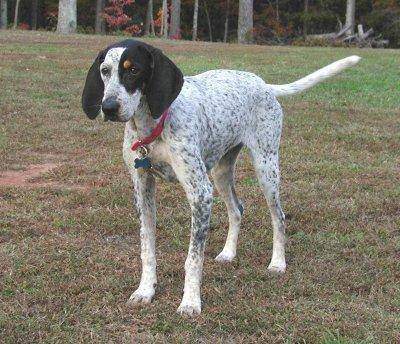

In [6]:
# View an image
from IPython.display import Image
Image("/content/drive/My Drive/Dog vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg")

### Getting images and their labels
 
 Get list of all image file pathnames

In [7]:
# Create pathnames from image ID's
filenames = ["drive/My Drive/Dog vision/train/"+fname+".jpg" for fname in labels_csv["id"]]
filenames[:10]

['drive/My Drive/Dog vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/Dog vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/Dog vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/Dog vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/Dog vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/My Drive/Dog vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/My Drive/Dog vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/My Drive/Dog vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/My Drive/Dog vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/My Drive/Dog vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [8]:
# Check whether number of file names matches the number of actual image files
import os
if len(os.listdir("drive/My Drive/Dog vision/train")) == len(filenames):
  print("File names match actual amount of file !")
else:
  print("Filename do not match the actual amount of files")

File names match actual amount of file !


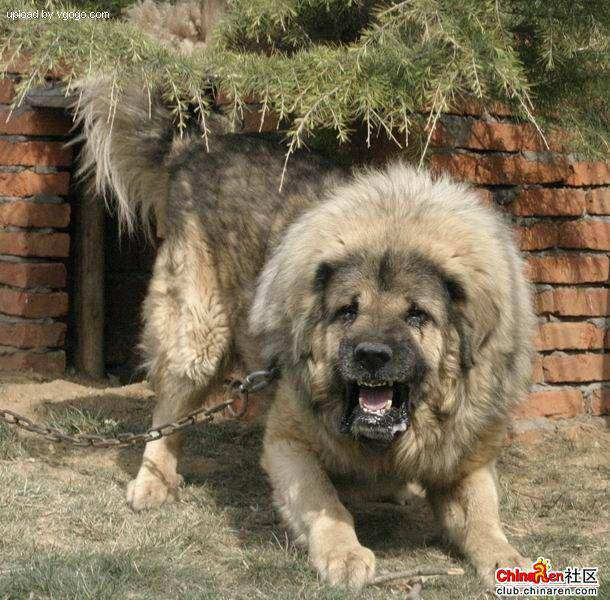

In [9]:
Image(filenames[9000])

In [10]:
labels_csv["breed"][9000]

'tibetan_mastiff'

In [11]:
# Prepare labels
import numpy as np
labels = labels_csv["breed"].to_numpy()
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [12]:
# Checking for missing data
if len(labels) == len (filenames):
  print("Number of labels matches number of filename !")
else:
  print("Number of labels does not match with number of filename")

Number of labels matches number of filename !


In [13]:
# Find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [14]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [15]:
# Turn every label into boolean array
boolean_labels = [label == unique_breeds for label in labels]
len(boolean_labels)

10222

In [16]:
# Turning boolean array into integers
print(labels[0])
print(np.where(unique_breeds == labels[0]))
print(boolean_labels[0].argmax())
print(boolean_labels[0].astype(int))

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [17]:
print(labels[2])
print(boolean_labels[2].astype(int))

pekinese
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


## 2. Creating Validation set

In [18]:
# Setup x and y variables
x = filenames
y = boolean_labels

Start of experimenting with ~1000 images and increase as needed

In [19]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type: "slider", min: 1000, max: 10000}

In [20]:
# Split data into train and valdiation sets
from sklearn.model_selection import train_test_split

# Splitting into 2 sets of total size NUM_IMAGES
x_train, x_val, y_train, y_val = train_test_split(x[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size = 0.2,
                                                  random_state = 8)

len(x_train), len(y_train), len(x_val), len(y_val)


(800, 800, 200, 200)

In [21]:
x_train[:5], y_train[:2]

(['drive/My Drive/Dog vision/train/0e403e86dc961d59fec94dfb62968a53.jpg',
  'drive/My Drive/Dog vision/train/01a3b064c56edbe3abf55051b16134d4.jpg',
  'drive/My Drive/Dog vision/train/010e87fdf252645a827e37470e65e842.jpg',
  'drive/My Drive/Dog vision/train/0743bfe9525b7a6310a297b11b7e154a.jpg',
  'drive/My Drive/Dog vision/train/17f5ba5fee5bbebe781009cf8d3e1809.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, Fa

##3. Preprocessing Images (Turning images into tensors)

To preprocess the images into tensors, a function needs to be created that does:
1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a varaiable, `image`
3. Turn `image` into tensors
4. Normalize the image
5. Resize the `image` to a size of (224, 224)
6. Return the modified `image`

Sample:

In [22]:
# Importing an image
from matplotlib.pyplot import imread
image = imread(filenames[42])
# turning into tensor
tf.constant(image)

<tf.Tensor: shape=(257, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]],

       [[ 56, 104,  66],
        [ 58, 106,  66],
        [ 64, 112,  72],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 73, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  13],
        [  6,  15,  14],
        ...,
        [120, 113,  67],
        [126, 118,  72],
        [122, 114,  67]],

       [[  0,   4,   6],
        [  0,   9,   8],
        [  1,  10,   9],
        ...,
        [105,  98,  52],
        [111, 104,  58],
        [111, 103,  56]],

       [[ 18,  16,  37],
        [ 18,  18,  28],
        [ 17,  20,  11],
        ...,
        [101,  92,  5

In [23]:
# Define image size
IMG_SIZE = 224

# Creating the preprocessing function
def process_image(image_path):
  """
  Takes an image file path and turns the image into tensors
  """
  # Read in an image file
  image = tf.io.read_file(image_path)

  # Turn jpg image into numerical tensor with 3 colour channels
  image = tf.image.decode_jpeg(image, channels = 3)

  # Normalization (Convert the colour channel values from 0-255 to 0-1 values)
  image = tf.image.convert_image_dtype(image, tf.float32)

  # Resize the image
  image = tf.image.resize(image, size = [IMG_SIZE, IMG_SIZE])

  return image

## 4. Turning data into batches

Why ?

WHen trying to process 10000 images in one go, they all might not fit into memory.

Thats why 32 (batch size) images is done at a time

To use TensorFlow effectively, the data need to be in the form of Tensor tuples like this:
`(images, label)`


In [24]:
# Create a function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes in an image file path name and the associated label,
  processes the image and returns a tuple of (image, label)
  """
  image = process_image(image_path)
  return image, label

In [25]:
# Demo
(process_image(x[42]),tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

A way to turn the data into tuples of Tensors in the form:`(image, label)`, create a function to turn all the data(x & y) into batches

In [26]:
# Define the batch size (32)
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(x, y = None, batch_size = BATCH_SIZE, valid_data = False, test_data = False):
  """
  Creates batches of data out of image (x) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it's validation data.
  Accepts test data as input (no labels)
  """
  # If test dataset (no labels)
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices(tf.constant(x)) # only filepaths
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # If valid dataset, no shuffling 
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                              tf.constant(y))) # labels
    data_batch  = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch
  
  # If Train dataset
  else:
    print("Creating training data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                              tf.constant(y))) # labels
    # Shuffling pathnames and labels 
    data = data.shuffle(buffer_size = len(x))
    data_batch  = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

In [27]:
# Create training and validation data batches
train_data = create_data_batches(x_train, y_train)
val_data = create_data_batches(x_val, y_val, valid_data = True)

Creating training data batches...
Creating validation data batches...


In [28]:
# Checking different attributes of the data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## 5. Visualize Data

In [29]:
import matplotlib.pyplot as plt

# Create a function for veiwing images in a data batch
def show_25_images(images, labels):
  """
  Display a plot of 25 images and their labels from a data batch
  """
  # Setup the figure
  plt.figure(figsize = (10, 10))
  # Loop thorugh 25 images
  for i in range(25):
    # Create subplots
    ax = plt.subplot(5, 5, i+1)
    plt.imshow(images[i])
    plt.title(unique_breeds[labels[i].argmax()])
    plt.axis("off")

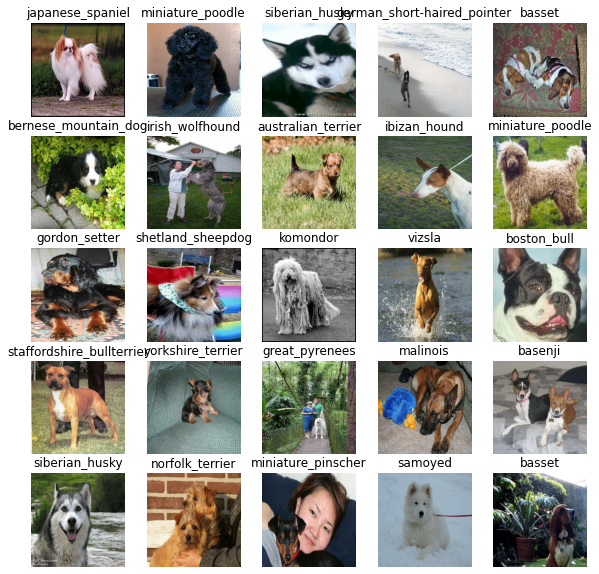

In [30]:
# Visualize training set
# getting data from the batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

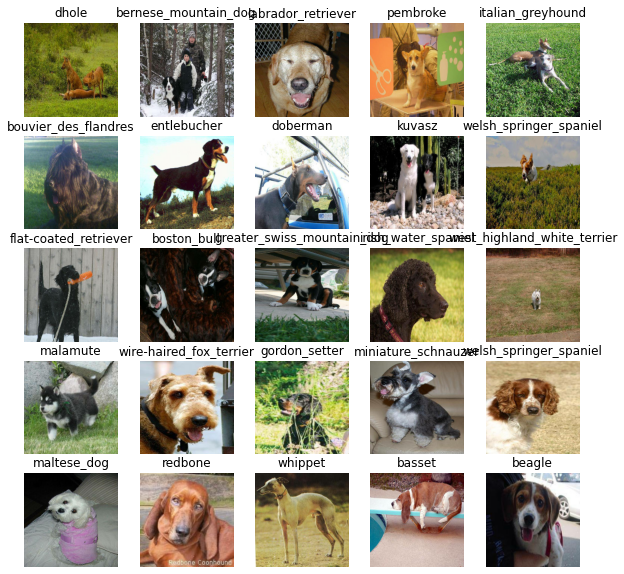

In [31]:
# Visualize validation set
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

## 6. Building a model

Few things to be defined:
- The input shape (images shape, in the form of Tensors) of the model
- The output shape (image labels, in the form of Tensors) of the model
- The URL of the model to be used - https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4

In [32]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, color channels

# Setup output shape of the model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

Putting the above things together into a keras deep learning model

Create a function which:
- Takes the input, output shape and model
- Defines the layers in a keras model in sequential fashion
- Compiles the model 
- Builds the model
- Returns the model

The steps can be found here: https://www.tensorflow.org/guide/keras/sequential_model

In [33]:
# Create a function which builds a Keras model
def create_model(input_shape = INPUT_SHAPE, output_shape = OUTPUT_SHAPE, model_url = MODEL_URL):
  print("Building model with: "+MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([
     hub.KerasLayer(MODEL_URL), # Layer 1 (Input layer)
     tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                           activation = "softmax") # Layer 2 (Output layer)
  ])

  # Complite the model
  model.compile(
      loss = tf.keras.losses.CategoricalCrossentropy(),
      optimizer = tf.keras.optimizers.Adam(),
      metrics = ["accuracy"]
  )

  # Build a model
  model.build(INPUT_SHAPE)

  return model

In [34]:
model= create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  5432713   
_________________________________________________________________
dense (Dense)                multiple                  120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


## Creating Callbacks

Helper functions that a model can use during training to do things like save progress, check or stop training early if a model stops improving.

2 callbacks to be created:
- Tensorboard - for checking the progress
- Early stopping

#### TensorBoard

1. Load the TensorBoard extension
2. Create a callback to save logs and pass it to our model's `fit()` function.
3. Visualize the models training log with the `%tensorboard` magic function

In [35]:
# Load TensorBoard notebook extension
%load_ext tensorboard

import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("/content/drive/My Drive/Dog vision/logs",
                         datetime.datetime.now().strftime("%Y%m%d - %H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

#### Early stopping callback

Helps stop the model from overfitting by stopping if a certain evaluation metric stops improving

In [36]:
# Creating early stopping callbakc
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience = 3)